In [1]:
# package
import numpy as np
from PIL import Image
import torch
from torch.optim import Adam
from torchvision import transforms
from torch.nn.functional import mse_loss
from torchvision import models

In [2]:
# initialize model
vgg = models.vgg19(pretrained=True).features

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /Users/vominhthinh/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [01:11<00:00, 8.00MB/s] 


In [5]:
vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [3]:
# iamge transformations
preprocess_steps = transforms.Compose([
    transforms.Resize((200, 200)),  # better (300, 300)
    transforms.ToTensor(),
])
content_img = Image.open('content.jpeg').convert('RGB')
content_img = preprocess_steps(content_img)
# transpose from C, H, W to H, W, C
# content_img = content_img.transpose(0, 2)
content_img = torch.unsqueeze(content_img, 0)
print(content_img.shape)

style_img = Image.open('style.jpg').convert('RGB')
style_img = preprocess_steps(style_img)
# style_img = style_img.transpose(0, 2)
style_img = torch.unsqueeze(style_img, 0)
print(style_img.shape)


torch.Size([1, 3, 200, 200])
torch.Size([1, 3, 200, 200])


In [6]:
# feature extraction
LOSS_LAYERS = { '0': 'conv1_1', 
                '5': 'conv2_1',  
                '10': 'conv3_1', 
                '19': 'conv4_1', 
                '21': 'conv4_2', 
                '28': 'conv5_1'}


def extract_features(x, model):
    features = {}   
    for name, layer in model._modules.items():
        x = layer(x)
        
        if name in LOSS_LAYERS:
            features[LOSS_LAYERS[name]] = x   
            
    return features

content_img_features = extract_features(content_img, vgg)
style_img_features   = extract_features(style_img, vgg)

In [7]:
def calc_gram_matrix(tensor):
    _, C, H, W = tensor.size()
    tensor = tensor.view(C, H * W)    
    gram_matrix = torch.mm(tensor, tensor.t())
    gram_matrix = gram_matrix.div(C * H * W)  # normalization required
    return gram_matrix

style_features_gram_matrix = {layer: calc_gram_matrix(style_img_features[layer]) for layer in 
                                                    style_img_features}

style_features_gram_matrix 

{'conv1_1': tensor([[2.2039e-05, 8.6958e-05, 5.2683e-10,  ..., 1.9456e-06, 5.9046e-05,
          1.1420e-04],
         [8.6958e-05, 2.6525e-03, 0.0000e+00,  ..., 1.2592e-03, 1.3361e-03,
          2.4284e-03],
         [5.2683e-10, 0.0000e+00, 1.1101e-06,  ..., 1.2172e-07, 3.7886e-06,
          7.6848e-06],
         ...,
         [1.9456e-06, 1.2592e-03, 1.2172e-07,  ..., 2.3507e-03, 1.1338e-03,
          1.7665e-03],
         [5.9046e-05, 1.3361e-03, 3.7886e-06,  ..., 1.1338e-03, 1.3037e-03,
          1.7995e-03],
         [1.1420e-04, 2.4284e-03, 7.6848e-06,  ..., 1.7665e-03, 1.7995e-03,
          3.3321e-03]], grad_fn=<DivBackward0>),
 'conv2_1': tensor([[0.0051, 0.0003, 0.0035,  ..., 0.0008, 0.0010, 0.0031],
         [0.0003, 0.0009, 0.0009,  ..., 0.0005, 0.0002, 0.0005],
         [0.0035, 0.0009, 0.0079,  ..., 0.0006, 0.0004, 0.0035],
         ...,
         [0.0008, 0.0005, 0.0006,  ..., 0.0022, 0.0013, 0.0010],
         [0.0010, 0.0002, 0.0004,  ..., 0.0013, 0.0024, 0.0016],
     

In [8]:
weights = {'conv1_1': 1.0, 'conv2_1': 0.8, 'conv3_1': 0.6,
           'conv4_1': 0.4, 'conv5_1': 0.2}

target = content_img.clone().requires_grad_(True)

optimizer = Adam([target], lr=0.003)

In [9]:
# train the model
for i in range(1, 100):
    
    target_features = extract_features(target, vgg)

    content_loss = mse_loss (target_features['conv4_2'], content_img_features['conv4_2'])
    
    style_loss = 0
    for layer in weights:
  
        target_feature = target_features[layer]
        target_gram_matrix = calc_gram_matrix(target_feature)
        style_gram_matrix = style_features_gram_matrix[layer]
        
        layer_loss = mse_loss (target_gram_matrix, style_gram_matrix) * weights[layer]
        # layer_loss *= weights[layer]
        

        style_loss += layer_loss  
    
    total_loss = 1000000 * style_loss + content_loss
    
    if i % 10 == 0:
        print (f"Epoch {i}:, Style Loss : {style_loss}, Content Loss : {content_loss}")
    
    optimizer.zero_grad()
    
    total_loss.backward(retain_graph=True)
    
    optimizer.step()

Epoch 10:, Style Loss : 1.7285477724726661e-06, Content Loss : 0.775153636932373
Epoch 20:, Style Loss : 1.3014620208195993e-06, Content Loss : 0.7471099495887756
Epoch 30:, Style Loss : 1.140365839091828e-06, Content Loss : 0.6967290639877319
Epoch 40:, Style Loss : 1.0422140803711955e-06, Content Loss : 0.6716852188110352
Epoch 50:, Style Loss : 9.78427124209702e-07, Content Loss : 0.6540750861167908
Epoch 60:, Style Loss : 9.303723231823824e-07, Content Loss : 0.6433959603309631
Epoch 70:, Style Loss : 8.939834401644475e-07, Content Loss : 0.6353601813316345
Epoch 80:, Style Loss : 8.628752539152629e-07, Content Loss : 0.6309650540351868
Epoch 90:, Style Loss : 8.384818670492677e-07, Content Loss : 0.626181960105896


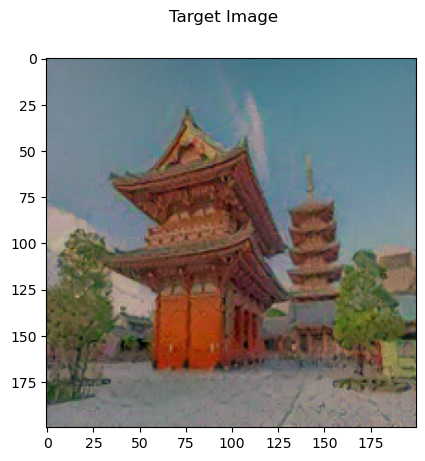

In [10]:
# get target image
mean = (0.485, 0.456, 0.406)  # imagenet mean and std
std = (0.229, 0.224, 0.225)
def tensor_to_image(tensor):

    image = tensor.clone().detach()
    image = image.cpu().numpy().squeeze()

    image = image.transpose(1, 2, 0)

    image *= np.array(std) + np.array(mean)
    image = image.clip(0, 1)

    return image


import matplotlib.pyplot as plt
img = tensor_to_image(target)
fig = plt.figure()
fig.suptitle('Target Image')
plt.imshow(img)